In [1]:
# Import standard libraries and relevant SKLearn modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Max columns and rows for easier viewing of certain operations below

# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [3]:
# Read in cleaned and engineered datasets

df_train = pd.read_csv('../data/train_cleaned_eng.csv')
df_test = pd.read_csv('../data/test_cleaned_eng.csv')

My first step in the modeling process was to establish a null hypothesis, represented by the mean of all the sale prices. I also then graphed the OLS regression in purple as an extra point of consideration and comparison.

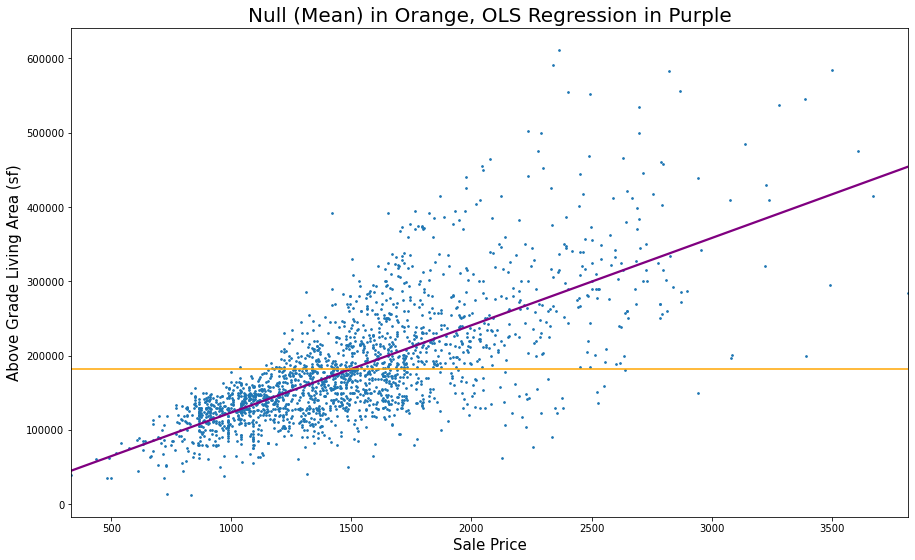

In [4]:
# Create baseline model

plt.figure(figsize=(15,9))
plt.scatter(df_train['gr_liv_area'], df_train['sale_price'], s=1)
sns.regplot('gr_liv_area', 'sale_price', df_train, ci=None, 
            scatter_kws = {'s': 3}, 
            line_kws = {'color': 'purple'})
plt.axhline(df_train['sale_price'].mean(), color='orange')
plt.xlabel('Sale Price', fontsize=15)
plt.ylabel('Above Grade Living Area (sf)', fontsize=15);
plt.title('Null (Mean) in Orange, OLS Regression in Purple', fontsize=20);

After running my EDA, cleaning and mapping, and processing any feature engineering, I compiled a list of all the columns I was considering using for my house pricing model. During the tuning process, however, I would come across new features I wanted to include and had to return to my Python file to map and reprocess the new data. In order to streamline the model tuning and testing process I created the feat_sel() function below. This function allowed me to comment in/out features that I wanted to test in my model. Rather than having to manually cut and paste in the feature columns, I was able to improve the workflow by also utitlizing the select_dtypes() function to automatically select the columns which required categorization using get_dummies().

In [5]:
# Create function to easily create different feature sets and test on model

def feat_sel(df):
    
    # Feature Selection for tuning
    X_features = ['Id', 
#                 'lot_area', 
                'street', 
#                 'land_cont', 
                'neighborhood', 
                'cond_1',
#                 'cond_2', 
                'bldg_type', 
                'style', 
                'overall_qual',
                'overall_cond',
                'yr_built', 
                'yr_remodeled', 
                'roof_style', 
#                 'roof_mater', 
                'exter_1',
#                 'exter_qual',
                'exter_cond', 
                'foundation', 
                'bsmt_qual',
                'bsmt_cond', 
                'bsmt_expo',
                'bsmt_fin_1',
#                 'bsmt_fin_1_sf', 
#                 'bsmt_fin_2', 
#                 'bsmt_fin_2_sf', 
#                 'bsmt_sf', 
#                 'heat',
                'cent_air', 
#                 'gr_liv_area', 
                'full_bath', 
                'half_bath',
#                 'bedrooms_gr', 
#                 'kitchen', 
                'kitch_qual', 
                'tot_rooms_gr', 
                'fireplaces', 
                'garage_type',
                'garage_car_size',
                'garage_cond', 
                'paved_drive', 
#                 'misc_val',
#                 'year_sold',
#                 'sale_price', 
#                 'has_pool', 
#                 'full_bath_shift',
#                 'half_bath_shift', 
#                 'bedrooms_gr_shift', 
#                 'fireplaces_shift',
#                 'garage_car_size_shift', 
#                 'lot_area_scaled_mm',
#                 'bsmt_fin_1_sf_scaled_mm', 
#                 'bsmt_fin_2_sf_scaled_mm',
#                 'bsmt_sf_scaled_mm', 
#                 'gr_liv_area_scaled_mm',
#                 'tot_rooms_gr_gr_liv_area', 
#                 'tot_rooms_gr_bedroom_gr',
#                 'full_bath_gr_liv_area', 
                'gar_car_size_overall_qual',
#                 'yr_built_overall_qual', 
                'full_bath_gr_liv_area_log',
#                 'tot_rooms_gr_bedroom_gr_log', 
#                 'lot_area_scaled_mm_log',
#                 'gr_liv_area_scaled_mm_log', 
                'bsmt_fin_1_sf_scaled_mm_log',
                'bsmt_fin_2_sf_scaled_mm_log',
                'bsmt_sf_scaled_mm_log',
                'bedrooms_gr_shift_log', 
#                 'tot_rooms_gr_log',
                'tot_rooms_gr_gr_liv_area_log',
                  'lot_area_log',
                  'gr_liv_area_log',
#                   'mas_vnr_type',
                  'bsmt_baths',
#                   'bsmt_full_bath',
#                   'bsmt_half_bath',
                  'functional',   
#                   'porch_sf',
#                   'functional_mapped',    
                  'functional_mapped_overall_qual',
#                   'wood_deck_sf',
#                   'wood_deck_sf_scaled_mm_log',
#                   'garage_qual',
#                   'garage_finish',
                  'ms_zoning'
               ]

    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html
    dummies_columns = list(df[X_features].select_dtypes(include='object'))
    
    if 'sale_price' not in df.columns:
        X_test = df[X_features]
        X_test = pd.get_dummies(data=X_test, columns=dummies_columns, drop_first=True)
        return X_test
    else:
        X_train = df[X_features]
        X_train = pd.get_dummies(data=X_train, columns=dummies_columns, drop_first=True)
        return X_train

y = df_train['sale_price']

Once I completed the function, I was able to run the train and test dataframes through the function to include only the features I was interested in and automatically create dummy columns. I then used the train_test_split() function in preparation for my Linear Regression model and took the log of my target to improve my model.

In [6]:
# Run train and test data through feat_sel() function

X_train_df = feat_sel(df_train)
X_test_df = feat_sel(df_test)

In [7]:
# Train, test (validate), split

X_train, X_validation, y_train, y_validation = train_test_split(X_train_df, y, random_state=42)

y_train_log = y_train.map(np.log)
y_validation_log = y_validation.map(np.log)

I instantiated and fit the model, displayed the coefficients, calculated predictions and residuals, and calculated my MSE, RMSE and r2 scores. Using these scores I was able to iterate over different sets of features and compare the strength of the model with these metrics. I also used these metrics to keep an eye on overfitting (and underfitting). My model consistently scored slightly higher for my training data than my validation (test) data, but not to the extent I felt it was overfit. My consistently high (or low, depending) scores indicated that I was not underfitting the model.

In [8]:
# Instantiate and fit the model

lr = LinearRegression()
lr.fit(X_train, y_train_log)

LinearRegression()

In [9]:
# Display first 10 calculated coefficients

list(zip(X_train.columns, lr.coef_))[:10]

[('Id', 1.006405823074225e-05),
 ('overall_qual', 0.05335238481263291),
 ('overall_cond', 0.04014551625440019),
 ('yr_built', 0.001834655491934809),
 ('yr_remodeled', 0.0010959368204941783),
 ('full_bath', 0.07431402165302665),
 ('half_bath', 0.006380854107537137),
 ('tot_rooms_gr', -0.0019887621405627887),
 ('fireplaces', 0.02444721189214722),
 ('garage_car_size', -0.038467289028167644)]

In [10]:
# Calculate predictions and residuals for the model

pred = lr.predict(X_train)
residuals = y_train_log - pred

validation_pred = lr.predict(X_validation)

In [11]:
# Calculate MSE and RMSE for the data

mse_train = metrics.mean_squared_error(y_train_log, pred)   # Compare to mse_validation to see if model is overfit,
rmse_train = np.sqrt(mse_train)   # Use this to compare model to model, not representative of $

mse_validation = metrics.mean_squared_error(y_validation_log, validation_pred)   # Compare to mse_train to see if model is overfit
rmse_validation = np.sqrt(mse_validation)   # Use this to compare model to model, not representative of $

print(f'The training MSE is: {mse_train}.')
print(f'The training RMSE is: {rmse_train}.')
print(f'The validation MSE is: {mse_validation}.')
print(f'The validation RMSE is: {rmse_validation}.')

The training MSE is: 0.010568052522169484.
The training RMSE is: 0.10280103366294273.
The validation MSE is: 0.016373309956852496.
The validation RMSE is: 0.1279582352052907.


In [12]:
# R2 training and validation score, closer to 1 the better

r2_train = lr.score(X_train, y_train_log)
r2_validation = lr.score(X_validation, y_validation_log)

print(f'The training R2 score is: {r2_train}.')
print(f'The validation R2 score is: {r2_validation}.')

The training R2 score is: 0.9375076375371625.
The validation R2 score is: 0.903518251292407.


I plotted the predictions vs. residuals to check the spread of the predictions. I also created a histogram to confirm that the residuals fell within a relatively normalized distribution.

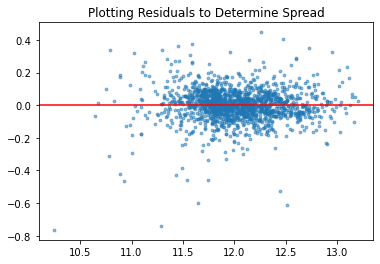

In [13]:
# View predictions vs. residuals to check the spread

plt.scatter(pred, residuals, s=8, alpha=.5)
plt.axhline(0, color='red')
plt.title('Plotting Residuals to Determine Spread');

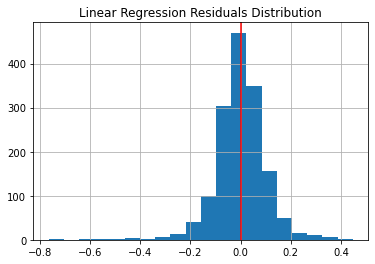

In [14]:
# View histogram of residuals to determine if somewhat normally distributed

residuals.hist(bins=20);
plt.axvline(0, color='red')
plt.title('Linear Regression Residuals Distribution');

Next I compared my null model to my linear regression model. To do so, I calculated my RMSE for both my null model and LR model and because my LR model had a much lower RMSE than my null model, it shows a marked improvement over the null model.

In [15]:
# Compare null hypothesis to model using MSE / RSME

df_train['null_pred'] = df_train['sale_price'].mean()

mse_null = metrics.mean_squared_error(df_train['sale_price'], df_train['null_pred'])
rmse_null = np.sqrt(mse_null) 

mse_train_compare = metrics.mean_squared_error(np.exp(y_train_log), np.exp(pred))
rmse_train_compare = np.sqrt(mse_train_compare)

print(f'The null RMSE is: {rmse_null}.')
print(f'The training RMSE is: {rmse_train_compare}.')

The null RMSE is: 79276.56098763691.
The training RMSE is: 19263.461294487737.


I then ran my test dataset through my model to predict prices for the Kaggle submission. I exponentiated the prices to return them to the correct units, created a new column with the values, and then created a dataframe with only the two required columns for submission. I previewed the head to circumvent any obvious issues and then saved my output to a CSV.

In [16]:
# Predict SalePrice for my test data

SalePrice = lr.predict(X_test_df)

In [17]:
# Exponentiate SalePrice to revert from logged values

SalePrice = np.exp(SalePrice)

In [18]:
# Add SalePrice column to df_test

df_test['SalePrice'] = SalePrice

In [19]:
# Filter/trim df_test to just the columns needed for the Kaggle submission

kaggle = df_test[['Id', 'SalePrice']]

In [20]:
# Check the df head to make sure the numbers look in the approximate range

kaggle.head()

,Id,SalePrice
0,2658,117796.217484
1,2718,157461.304916
2,2414,218038.720269
3,1989,108760.729622
4,625,163942.961227


In [21]:
# Save Kaggle submission to CSV

# kaggle.to_csv('../data/submissions/jsalisbury_80.csv', index=False)

Lastly, I pickled my model and saved any necessary outputs for future steps.

In [22]:
# Pickling code adapted from Charlie's lesson
# Import libraries to create pickle file

import pickle
import os

try:
    os.mkdir('../assets')
except:
    print('Assets folder already exists.')

Assets folder already exists.


In [23]:
# Pickle the model and save associated files

pickle.dump(lr, open('../assets/lr.pkl', 'wb'))
X_train.to_csv('../data/X_train.csv', index=False)
X_train_df.to_csv('../data/X_train_df.csv', index=False)
y.to_csv('../data/y.csv', index=False)